# 1. Import libraries

In [2]:
# Import necessary libraries
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from google.colab import drive
import numpy as np

# From here, add any libraries that you might need for the rest of your code
import PIL
from PIL import Image
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Concatenate
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D, Resizing, Lambda
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from keras.callbacks import EarlyStopping


# 2. Load and pre-process the dataset

In [3]:
# Set the paths based on your Drive directory
data_dir = os.getcwd() # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: /home/jupyter/DL
Training directory: /home/jupyter/DL/Training
Testing directory: /home/jupyter/DL/Testing


In [4]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# Load and preprocess the data
np.random.seed(seed=42)
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale'
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode='grayscale'
    )

    return train_data, test_data

# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [5]:
# Convert the target values using the proper function for one hot encoding

# Function to check one-hot encoding
def check_one_hot_encoding(data_iterator):
    # Get a batch of data
    images, labels = next(data_iterator)
    
    # Print one-hot encoded labels
    print("Sample one-hot encoded labels:")
    print(labels[:5])

# Check one-hot encoding for training data
check_one_hot_encoding(train_data)

# Optionally, check one-hot encoding for test data
check_one_hot_encoding(test_data)

Sample one-hot encoded labels:
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
Sample one-hot encoded labels:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


# 3. Visualise data and plot data distribution

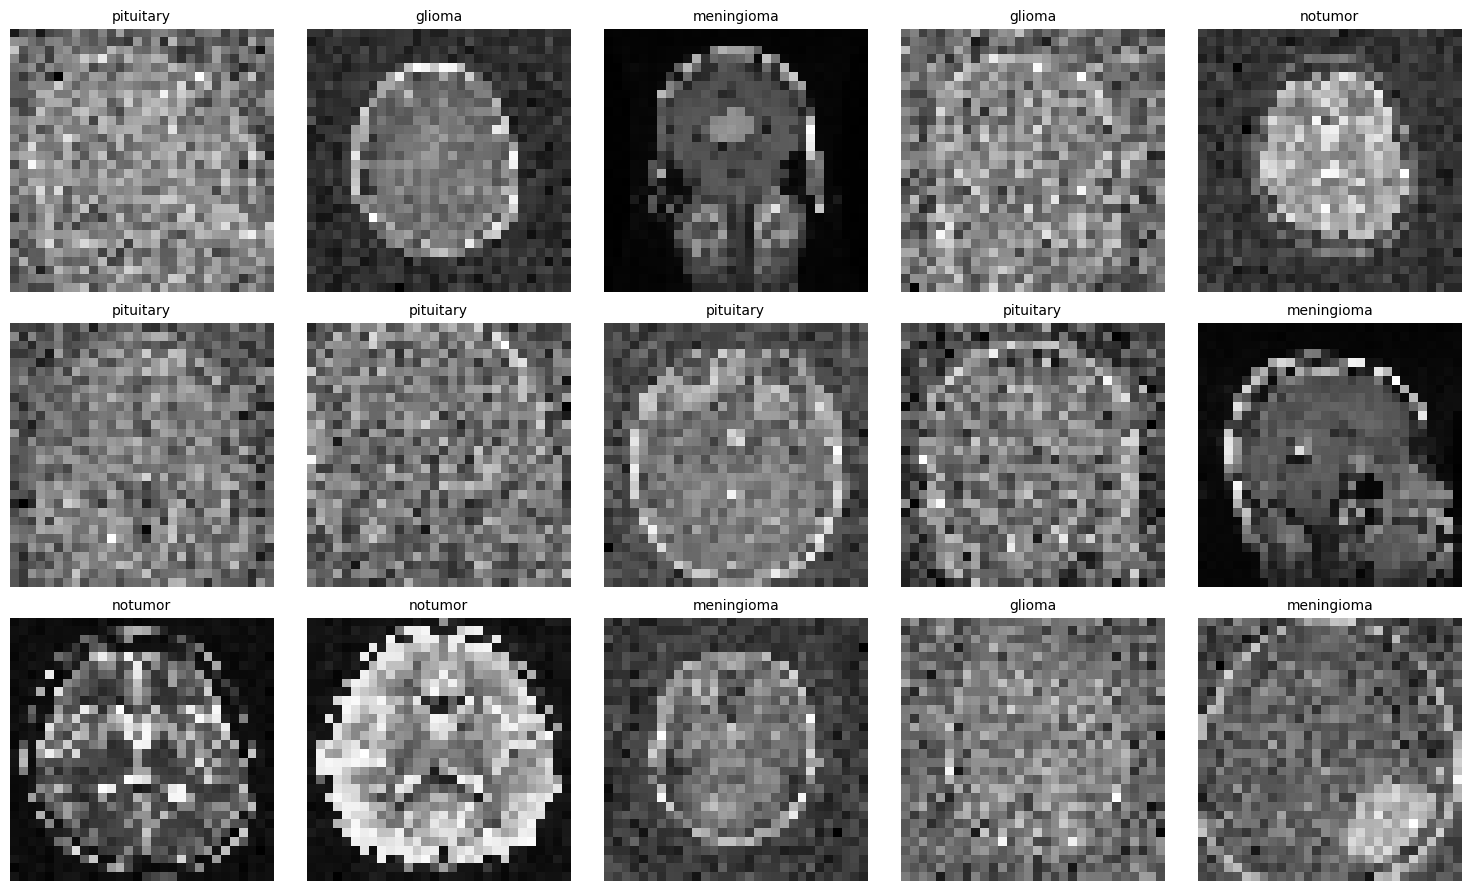

<Figure size 640x480 with 0 Axes>

In [6]:
# Randomly select 15 samples from the dataset.
# For each selected sample, display the image along with its corresponding label as text on top of the image. 
# Arrange these images and labels in a single figure, ensuring that they are visually clear and labeled properly.

# Function to randomly select and display images with labels
def display_random_samples(data_iterator):
    # Get a batch of data
    images, labels = next(data_iterator)
    batch_size = len(images)

    # Randomly select 15 indices
    indices = np.random.choice(batch_size, 15, replace=False)
    
    # Prepare the figure
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        image = images[idx]
        label = labels[idx]
        
        # Display image
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].axis('off')
        
        # Display label
        class_idx = np.argmax(label)
        class_name = list(train_data.class_indices.keys())[class_idx]
        axes[i].set_title(class_name, fontsize=10)
    
    plt.tight_layout()

    # Save figure 
    plt.savefig('random_samples.png')

    # Show plot
    plt.show()

    plt.close()
    plt.clf()

# Display random samples from training data
display_random_samples(train_data)

           Class
0      pituitary
1        notumor
2         glioma
3     meningioma
4      pituitary
...          ...
1274   pituitary
1275   pituitary
1276   pituitary
1277   pituitary
1278   pituitary

[6959 rows x 1 columns]
Class
notumor       1996
pituitary     1747
meningioma    1635
glioma        1581
Name: count, dtype: int64


/tmp/ipykernel_81/1443405962.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


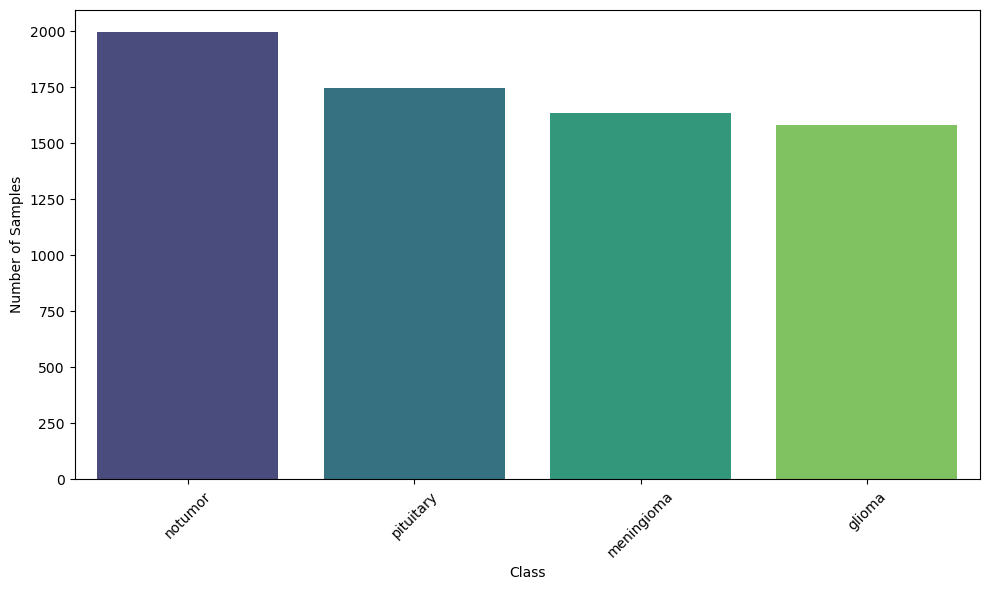

<Figure size 640x480 with 0 Axes>

In [7]:
# Create a bar plot to visualize the class label distribution of the dataset. 

def plot_class_distribution(df):
    # Get counts per class
    class_counts = df['Class'].value_counts()
    print(class_counts)

    # Create figure
    plt.figure(figsize=(10, 6))
    sb.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save figure
    plt.savefig('class_distribution.png')

    # Show plot
    plt.show()

    plt.close()
    plt.clf()

# Function to get all labels from the data generator
def gather_labels(data_iterator):
    labels = []
    for _ in range(data_iterator.samples // data_iterator.batch_size):
        _, batch_labels = next(data_iterator)
        labels.extend(batch_labels.argmax(axis=1))  # Get class indices from one-hot encoded labels
    class_names = list(data_iterator.class_indices.keys())
    label_names = [class_names[label] for label in labels]
    return pd.DataFrame({'Class': label_names})

# Gather labels
train_labels = gather_labels(train_data)
test_labels = gather_labels(test_data)
all_labels = pd.concat([train_labels, test_labels], axis=0)
print(all_labels)

# Plot and save class distribution for the full dataset
plot_class_distribution(all_labels)


# 4. Train and Evaluation functions

In [8]:
# Apply 20% of the training set as a validation set to validate the hyperparameters that you have chosen.

def extract_data_from_generator(generator):
    X = []
    y = []
    for i in range(len(generator)):
        X_batch, y_batch = generator[i]
        X.extend(X_batch)
        y.extend(y_batch)
    return np.array(X), np.array(y)

# Extract training and validation data from generators
X_train, y_train = extract_data_from_generator(train_data)
X_test, y_test = extract_data_from_generator(test_data)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")
print(f"Number of test samples: {len(X_test)}")


Number of training samples: 4569
Number of validation samples: 1143
Number of test samples: 1311


In [9]:
# BASELINE CNN MODEL

# Create the CNN model
baseline_model = Sequential()

# First convolutional layer with 32 filters, kernel size 3x3, ReLU activation, followed by a 2x2 max pooling layer
baseline_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_res, image_res, 1)))  # Assuming grayscale input, hence the '1' in input_shape
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer with 32 filters, kernel size 3x3, ReLU activation, followed by a 2x2 max pooling layer
baseline_model.add(Conv2D(32, (3, 3), activation='relu'))
baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the convolutional layers
baseline_model.add(Flatten())

# Dense layer with 32 neurons and ReLU activation
baseline_model.add(Dense(32, activation='relu'))

# Output layer with softmax activation for multi-class classification
num_classes = len(train_data.class_indices)
baseline_model.add(Dense(num_classes, activation='softmax'))

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
baseline_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
baseline_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 32)                3

In [10]:
# OPTIMIZABLE CNN MODEL

# Function to build the optimizable model
def build_model(layers=2, filters=32, kernel_size=3, activation='relu', optimizer='adam', dense_units=64, dropout_rate=0.2):
    model = Sequential()
    
    # Input layer (grayscale image, so channels = 1)
    model.add(Input(shape=(image_res, image_res, 1)))
    
    # Initialize max pooling count
    max_pool_count = 0
    
    # Add convolutional and pooling layers
    for i in range(layers):
        model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same'))
        
        # Randomly decide whether to add MaxPooling, but only if fewer than 2 MaxPooling layers have been added
        if max_pool_count < 2 and random.choice([True, False]):
            model.add(MaxPooling2D(pool_size=(2, 2)))
            max_pool_count += 1  # increment MaxPooling count after each addition

    # Flatten the convolutional layers
    model.add(Flatten())
    
    # Fully connected Dense layer
    model.add(Dense(dense_units, activation=activation))
    
    # Optional Dropout layer for regularization
    model.add(Dropout(rate=dropout_rate))
    
    # Output layer
    num_classes = len(train_data.class_indices)
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
# OPTIMIZABLE TRANSFER LEARNING MODEL

# Function to build the optimizable transfer learning model
def build_transfer_model(dense_units_1=1024, dense_units_2=1024, dense_units_3=512, optimizer='adam', learning_rate=1e-3):
    # Input
    input_shape = (30, 30, 1)
    inputs = tf.keras.Input(shape=input_shape)

    # Resizing and converting grayscale to RGB
    resized_inputs = Resizing(75, 75)(inputs)
    rgb_inputs = tf.keras.layers.Lambda(lambda x: tf.image.grayscale_to_rgb(x))(resized_inputs)

    # VGG16 model (with input resized to 32x32)
    vgg16_inputs = Resizing(32, 32)(rgb_inputs)
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    vgg16.trainable = False
    vgg16_output = vgg16(vgg16_inputs)

    # InceptionV3 model (input size 75x75)
    inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))
    inception.trainable = False
    inception_output = inception(rgb_inputs)

    # Flatten both model outputs
    vgg16_output_flat = Flatten()(vgg16_output)
    inception_output_flat = Flatten()(inception_output)

    # Concatenate the outputs of VGG16 and InceptionV3
    merged_output = Concatenate()([vgg16_output_flat, inception_output_flat])

    # Adding AlexNet-like fully connected layers
    x = Dense(dense_units_1, activation='relu')(merged_output)
    x = Dense(dense_units_2, activation='relu')(x)
    x = Dense(dense_units_3, activation='relu')(x)

    # Output layer (set the number of classes dynamically)
    num_classes = len(train_data.class_indices)
    output = Dense(num_classes, activation='softmax')(x)

    # Set optimizer with learning rate
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    # Build the model
    model = Model(inputs, output)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [12]:
# ACCURACY/LOSS PLOT

def plot_loss_accuracy(history, title):
    # Get best loss and accuracy Scores
    best_epoch_loss = history.history['val_loss'].index(min(history.history['val_loss']))
    best_epoch_accuracy = history.history['val_accuracy'].index(max(history.history['val_accuracy']))
    
    # Prepare figure
    plt.figure(figsize=(12, 4))
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot loss
    plt.subplot(1,2,1)
    plt.title(title + ' Training and Validation Loss')
    plt.plot(epochs, history.history['loss'], color='olive', label='training')
    plt.plot(epochs, history.history['val_loss'], color='navy', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.grid(True) 
    plt.gca().set_facecolor('lightgray') 
    plt.scatter(best_epoch_loss + 1, history.history['val_loss'][best_epoch_loss], color='red', label='best epoch')
    plt.legend(['training', 'validation', 'best epoch'])
    plt.xticks(range(0, 11))

    # Plot accuracy
    plt.subplot(1,2,2)
    plt.title(title + ' Training and Validation Accuracy')
    plt.plot(epochs, history.history['accuracy'], color='olive', label='training')
    plt.plot(epochs, history.history['val_accuracy'], color='navy', label='validation')
    plt.xlabel('Epochs')
    plt.ylabel("Accuracy")
    plt.grid(True) 
    plt.gca().set_facecolor('lightgray') 
    plt.scatter(best_epoch_accuracy + 1, history.history['val_accuracy'][best_epoch_accuracy], color='red', label='best epoch')
    plt.legend(['training', 'validation', 'best epoch'])
    plt.xticks(range(0, 11))

    plt.subplots_adjust(hspace=0.3)
    
    # Save figure 
    plt.savefig(f'{title} Loss and Accuracy.png')

    # Show plot
    plt.show()

    plt.close()
    plt.clf()


In [13]:
# ROC CURVE

def plot_roc_lines(fpr, tpr, roc_auc, y_true, y_pred, n_classes, labels, title, data_type):
    fig, ax = plt.subplots(figsize=(6, 4))
    roc_auc_micro = roc_auc["micro"]
    roc_auc_macro = roc_auc["macro"]

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (area = {roc_auc_micro:.2f})",
        color="goldenrod",
        linestyle="--",
        linewidth=3)

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (area = {roc_auc_macro:.2f})",
        color="midnightblue",
        linestyle=":",
        linewidth=3)

    colors = cycle(["coral", "olive", "teal", "purple"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_true[:, class_id],
            y_pred[:, class_id],
            name=f"ROC curve for ({np.unique(labels)[class_id]})",
            color=color,
            ax=ax)
        print()

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} {data_type} ROC curve for multi-class classification")
    plt.grid(True) 
    plt.gca().set_facecolor('lightgray') 
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Save figure 
    plt.savefig(f'{title} {data_type} ROC Curve.png')

    # Show plot
    plt.show()

    plt.close()
    plt.clf()

def calculate_roc(y_pred, y_true, title, data_type):
    labels = list(train_data.class_indices.keys())
    n_classes = len(np.unique(labels))
        
    # Make labels binary for one-vs-rest classification
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])

    # Turn prediction probabilities into a numpy array
    y_pred = np.array(y_pred)

    # Store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Calculating ROC and AUC for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plot_roc_lines(fpr, tpr, roc_auc, y_true_bin, y_pred, n_classes, labels, title, data_type)
    

In [14]:
# CONFUSION MATRIX

def confu_matrix(data_input, y_pred, y_true, model_type, data_type):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print(cm)
    print('test_accuracy: %.3f' % (acc))
    class_labels = list(data_input.class_indices.keys())

    s = sb.heatmap(cm,  cmap='YlGnBu', annot=True, fmt=".0f", xticklabels = class_labels)
    s.set(title = f'{model_type} Confusion matrix on the {data_type} set', xlabel='Predicted', ylabel='True')
    s.set_xlabel("Predicted", fontsize = 15)
    s.set_ylabel("True", fontsize = 15)
    s.yaxis.set_ticklabels(class_labels, rotation=90, va="center")
    
    # Save figure 
    plt.savefig(f'{model_type} {data_type} Confusion Matrix.png')

    # Show plot
    plt.show()

    plt.close()
    plt.clf()


In [15]:
# PERFORMANCE METRICS

def calculate_performance_measures(model, X, y, threshold=0.5):
    X_test = X
    y_test = y
    
    # Predict probabilities for test set
    yhat_probs = model.predict(X_test, verbose=0)
    
    # Predict classes for test set
    yhat_classes = (yhat_probs > threshold).argmax(axis=1)
    y_test_decoded = y_test.argmax(axis=1)

    print()
    print("--------------------------------------------------------------------")

    # Accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test_decoded, yhat_classes)
    
    # Precision tp / (tp + fp)
    precision = precision_score(y_test_decoded, yhat_classes, average='weighted')
    
    # Recall: tp / (tp + fn)
    recall = recall_score(y_test_decoded, yhat_classes, average='weighted')
    
    # F1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test_decoded, yhat_classes, average='weighted')
    
    # # ROC AUC
    # auc = roc_auc_score(y_test, yhat_probs, average='weighted')
    
    # # confusion matrix
    # matrix = confusion_matrix(y_test_decoded, yhat_classes)
    # print(matrix)

    results = [accuracy, precision, recall, f1] #auc
    return results
    

# 5. Model training

In [16]:
# BASELINE CNN MODEL

baseline_history = baseline_model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32)


Epoch 1/10
143/143 [==============================] - 14s 89ms/step - loss: 1.0081 - accuracy: 0.5734 - val_loss: 0.7505 - val_accuracy: 0.7165
Epoch 2/10
143/143 [==============================] - 12s 85ms/step - loss: 0.7126 - accuracy: 0.7255 - val_loss: 0.6282 - val_accuracy: 0.7585
Epoch 3/10
143/143 [==============================] - 12s 82ms/step - loss: 0.6291 - accuracy: 0.7568 - val_loss: 0.6372 - val_accuracy: 0.7664
Epoch 4/10
143/143 [==============================] - 12s 81ms/step - loss: 0.5861 - accuracy: 0.7698 - val_loss: 0.6001 - val_accuracy: 0.7533
Epoch 5/10
143/143 [==============================] - 12s 83ms/step - loss: 0.5304 - accuracy: 0.7967 - val_loss: 0.5451 - val_accuracy: 0.8031
Epoch 6/10
143/143 [==============================] - 13s 91ms/step - loss: 0.4901 - accuracy: 0.8081 - val_loss: 0.5300 - val_accuracy: 0.7944
Epoch 7/10
143/143 [==============================] - 12s 86ms/step - loss: 0.4699 - accuracy: 0.8188 - val_loss: 0.6153 - val_accuracy:

In [4]:
# MODEL OPTIMIZATION

# Wrap the model using KerasClassifier
model = KerasClassifier(build_fn=build_model)

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'layers': [2, 3],  
    'filters': [32, 64], 
    'kernel_size': [3, 5],  
    'activation': ['relu', 'sigmoid', 'tanh'],  
    'optimizer': ['adam', 'sgd', 'rmsprop'], 
    'dense_units': [32, 64],  
    'dropout_rate': [0.1],  
    'batch_size': [32],
    'epochs': [10]  
}

# Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

# Set up the GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=2)

# Perform the grid search
grid_result = grid.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Output the best hyperparameters
print(f"Best Accuracy: {grid_result.best_score_} using {grid_result.best_params_}")

# Get the best model from GridSearchCV
best_model = grid_result.best_estimator_.model
best_model.summary()


C:\Users\rick-\AppData\Local\Temp\ipykernel_30592\4080276986.py:63: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model)


Fitting 3 folds for each of 144 candidates, totalling 432 fits
Epoch 1/10
96/96 [==============================] - 5s 40ms/step - loss: 1.1106 - accuracy: 0.5031 - val_loss: 1.0938 - val_accuracy: 0.5600
Epoch 2/10
96/96 [==============================] - 4s 38ms/step - loss: 0.7239 - accuracy: 0.7204 - val_loss: 1.1312 - val_accuracy: 0.6144
Epoch 3/10
96/96 [==============================] - 4s 39ms/step - loss: 0.5544 - accuracy: 0.7968 - val_loss: 0.9162 - val_accuracy: 0.6564
Epoch 4/10
96/96 [==============================] - 4s 39ms/step - loss: 0.4463 - accuracy: 0.8323 - val_loss: 0.8912 - val_accuracy: 0.6819
Epoch 5/10
96/96 [==============================] - 4s 39ms/step - loss: 0.4217 - accuracy: 0.8392 - val_loss: 0.8944 - val_accuracy: 0.6933
Epoch 6/10
96/96 [==============================] - 4s 39ms/step - loss: 0.3409 - accuracy: 0.8733 - val_loss: 1.1949 - val_accuracy: 0.6424
Epoch 7/10
96/96 [==============================] - 4s 38ms/step - loss: 0.2931 - accuracy:

[0.7327290773391724, 0.7212970852851868]

In [17]:
# BUILD OPTIMIZED MODEL

# GridSearch indicated optimal parameters: 
# {'activation': 'relu', 
# 'batch_size': 32, 
# 'dense_units': 64, 
# 'dropout_rate': 0.1, 
# 'epochs': 10, 
# 'filters': 32, 
# 'kernel_size': 5, 
# 'layers': 3, 
# 'optimizer': 'adam'}

model = build_model(layers=3, filters=32, kernel_size=5, activation='relu', optimizer='adam', dense_units=64, dropout_rate=0.1)
model_history = model.fit(X_train, y_train, 
                          validation_data=(X_val, y_val),
                          epochs = 10,
                          batch_size=32)


Epoch 1/10
143/143 [==============================] - 122s 845ms/step - loss: 0.9364 - accuracy: 0.6008 - val_loss: 0.6617 - val_accuracy: 0.7524
Epoch 2/10
143/143 [==============================] - 120s 837ms/step - loss: 0.6329 - accuracy: 0.7549 - val_loss: 0.5813 - val_accuracy: 0.7883
Epoch 3/10
143/143 [==============================] - 120s 837ms/step - loss: 0.5287 - accuracy: 0.8011 - val_loss: 0.5100 - val_accuracy: 0.7935
Epoch 4/10
143/143 [==============================] - 119s 830ms/step - loss: 0.4369 - accuracy: 0.8348 - val_loss: 0.4962 - val_accuracy: 0.8154
Epoch 5/10
143/143 [==============================] - 120s 841ms/step - loss: 0.3712 - accuracy: 0.8591 - val_loss: 0.5265 - val_accuracy: 0.7944
Epoch 6/10
143/143 [==============================] - 118s 828ms/step - loss: 0.2930 - accuracy: 0.8877 - val_loss: 0.4859 - val_accuracy: 0.8338
Epoch 7/10
143/143 [==============================] - 120s 837ms/step - loss: 0.2271 - accuracy: 0.9164 - val_loss: 0.4913 -

In [21]:
# TRANSFER MODEL OPTIMIZATION

# Wrap the model using KerasClassifier
transfer_model = KerasClassifier(build_fn=build_transfer_model, epochs=10, batch_size=32, verbose=1)

# Define the hyperparameter grid
param_grid = {
    'dense_units_1': [1024, 2048],
    'dense_units_2': [1024, 2048],
    'dense_units_3': [512, 768],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [1e-3, 1e-2]
}

# Grid search with no parallelism (n_jobs=1)
grid = GridSearchCV(estimator=transfer_model, param_grid=param_grid, cv=3, n_jobs=1)

# Run the grid search 
grid_result = grid.fit(X_train, y_train)

# Output the best hyperparameters and results
print(f"Best Accuracy: {grid_result.best_score_} using {grid_result.best_params_}")

# Best model summary
best_transfer_model = grid_result.best_estimator_.model
best_transfer_model.summary()

# Use best model for further training with validation data
history = best_transfer_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


C:\Users\rick-\AppData\Local\Temp\ipykernel_28544\1071890210.py:76: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
96/96 [==============================] - 13s 110ms/step - loss: 1.1091 - accuracy: 0.5195
Epoch 2/10
96/96 [==============================] - 10s 109ms/step - loss: 0.7696 - accuracy: 0.6679
Epoch 3/10
96/96 [==============================] - 11s 111ms/step - loss: 0.6595 - accuracy: 0.7246
Epoch 4/10
96/96 [==============================] - 11s 110ms/step - loss: 0.5665 - accuracy: 0.7607
Epoch 5/10
96/96 [==============================] - 10s 108ms/step - loss: 0.5006 - accuracy: 0.7955
Epoch 6/10
96/96 [==============================] - 10s 109ms/step - loss: 0.4214 - accuracy: 0.8254
Epoch 7/10
96/96 [==============================] - 10s 109ms/step - loss: 0.4001 - accuracy: 0.8448
Epoch 8/10
96/96 [==============================] - 10s 108ms/step - loss: 0.3340 - accuracy: 0.8733
Epoch 9/10
96/96 [==============================] - 10s 108ms/step - loss: 0.2449 - accuracy: 0.9032
Epoch 10/10
48/48 [==============================] - 5s 93ms/step - loss: 1.3008 - accuracy

In [ ]:
# BUILD OPTIMIZED TRANSFER LEARNING MODEL

# GridSearch indicated optimal parameters: 
# {'dense_units_1': 2048, 
# 'dense_units_2': 1024, '
# dense_units_3': 768, 
# 'learning_rate': 0.001, 
# 'optimizer': 'adam'}

transfer_model = build_transfer_model(dense_units_1=2048, dense_units_2=1024, dense_units_3=768, optimizer='adam', learning_rate=0.001)
transfer_history = transfer_model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32)


Epoch 1/10
143/143 [==============================] - 359s 2s/step - loss: 1.0747 - accuracy: 0.5496 - val_loss: 0.8546 - val_accuracy: 0.6597
Epoch 2/10
143/143 [==============================] - 307s 2s/step - loss: 0.7759 - accuracy: 0.6748 - val_loss: 0.8856 - val_accuracy: 0.6457
Epoch 3/10
143/143 [==============================] - 308s 2s/step - loss: 0.6638 - accuracy: 0.7269 - val_loss: 0.8739 - val_accuracy: 0.6518
Epoch 4/10
143/143 [==============================] - 312s 2s/step - loss: 0.5619 - accuracy: 0.7774 - val_loss: 0.9128 - val_accuracy: 0.6719
Epoch 5/10
143/143 [==============================] - 305s 2s/step - loss: 0.4813 - accuracy: 0.8063 - val_loss: 0.8094 - val_accuracy: 0.7017
Epoch 6/10
143/143 [==============================] - 303s 2s/step - loss: 0.4302 - accuracy: 0.8286 - val_loss: 1.0222 - val_accuracy: 0.6842
Epoch 7/10
143/143 [==============================] - 305s 2s/step - loss: 0.3228 - accuracy: 0.8724 - val_loss: 1.1944 - val_accuracy: 0.6614

# 6. Model evaluation


--------------------------------------------------------------------
[0.8693368351936966, 0.876011888200269, 0.8693368351936966, 0.8673299159404334]

--------------------------------------------------------------------
[0.8101487314085739, 0.8138812057056369, 0.8101487314085739, 0.8067033596371311]

--------------------------------------------------------------------
[0.7749809305873379, 0.7725288680794958, 0.7749809305873379, 0.7657910048765745]


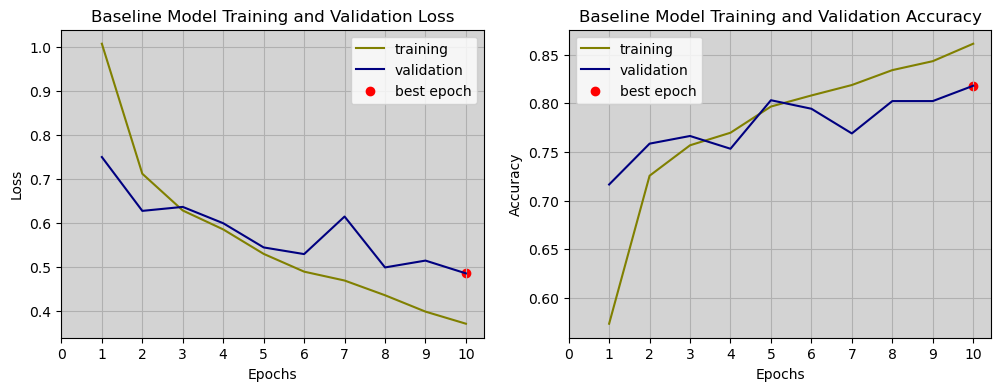

41/41 [==============================] - 1s 20ms/step
[[213  27   5  13]
 [ 56 148  22  27]
 [ 12  13 286   7]
 [  7  14   5 288]]
test_accuracy: 0.818


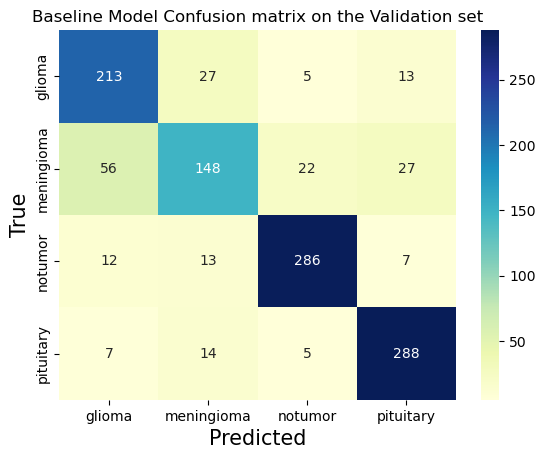

[[235  49   0  16]
 [ 57 149  74  26]
 [ 18  12 367   8]
 [ 12  10   5 273]]
test_accuracy: 0.781


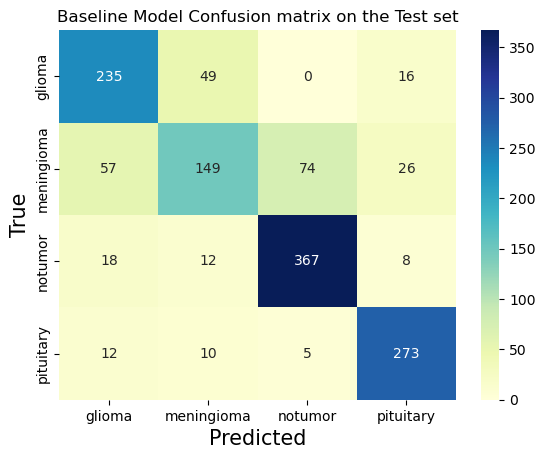

<Figure size 640x480 with 0 Axes>

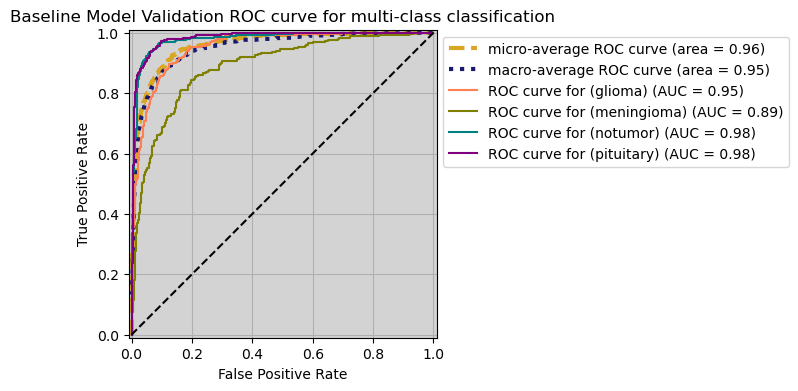

<Figure size 640x480 with 0 Axes>

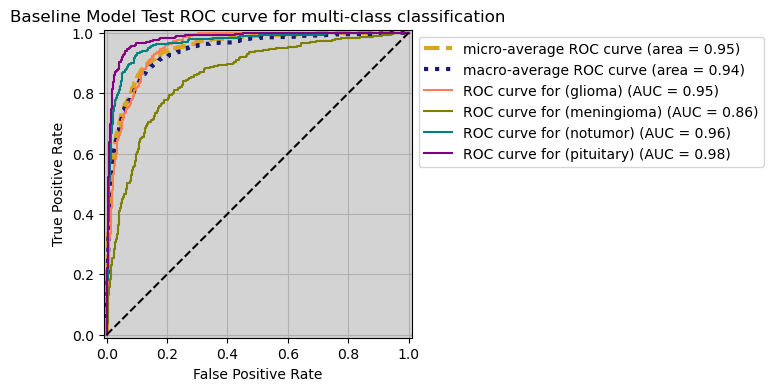

<Figure size 640x480 with 0 Axes>

In [18]:
# BASELINE EVALUATION 

# Evaluation metrics
print(calculate_performance_measures(baseline_model, X_train, y_train, threshold=0.5))
print(calculate_performance_measures(baseline_model, X_val, y_val, threshold=0.5))
print(calculate_performance_measures(baseline_model, X_test, y_test, threshold=0.5))

# Show loss/accuracy plot
plot_loss_accuracy(baseline_history, "Baseline Model")

# Predictions for entire validation dataset
y_pred_val_probs = baseline_model.predict(X_val)  # Predict for validation data samples
y_pred_val = np.argmax(y_pred_val_probs, axis=1)  # Get the predicted class index
y_true_val = np.argmax(y_val, axis=1)  # Get true class indices from one-hot encoded labels
    
# Predictions for entire test data set
y_pred_test_probs = baseline_model.predict(X_test)  # Predict for validation data samples
y_pred_test = np.argmax(y_pred_test_probs, axis=1)  # Get the predicted class index
y_true_test = np.argmax(y_test, axis=1)  # Get true class indices from one-hot encoded labels

# Show confusion matrices
confu_matrix(train_data, y_pred_val, y_true_val, "Baseline Model", "Validation")
confu_matrix(train_data, y_pred_test, y_true_test, "Baseline Model", "Test")

# Show ROC curves
calculate_roc(y_pred_val_probs, y_true_val, "Baseline Model", "Validation")
calculate_roc(y_pred_test_probs, y_true_test, "Baseline Model", "Test")



--------------------------------------------------------------------
[0.9888378200919238, 0.9888828143228288, 0.9888378200919238, 0.9888467241004625]

--------------------------------------------------------------------
[0.8223972003499562, 0.8295287954625127, 0.8223972003499562, 0.8249520810955446]

--------------------------------------------------------------------
[0.8222730739893211, 0.8219524254538676, 0.8222730739893211, 0.821872946582487]


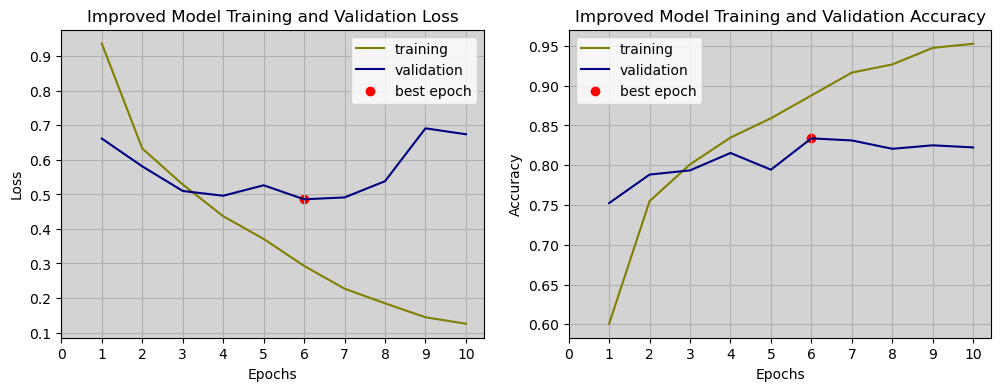

41/41 [==============================] - 7s 163ms/step
[[200  49   2   7]
 [ 42 180  10  21]
 [ 14  24 275   5]
 [  8  19   2 285]]
test_accuracy: 0.822


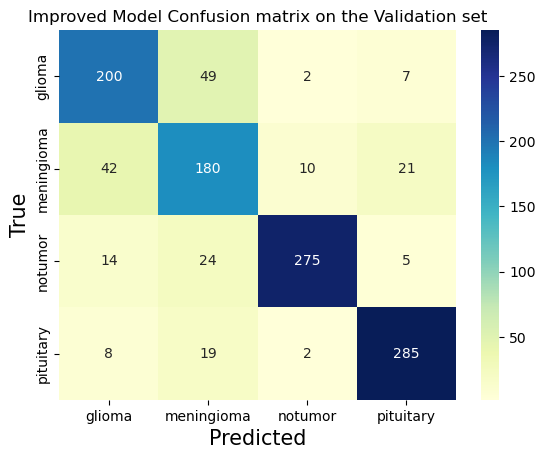

[[227  61   3   9]
 [ 41 214  32  19]
 [ 17  20 359   9]
 [ 10   9   1 280]]
test_accuracy: 0.824


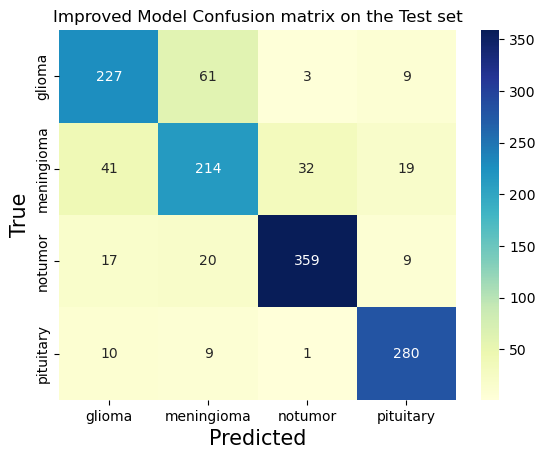

<Figure size 640x480 with 0 Axes>

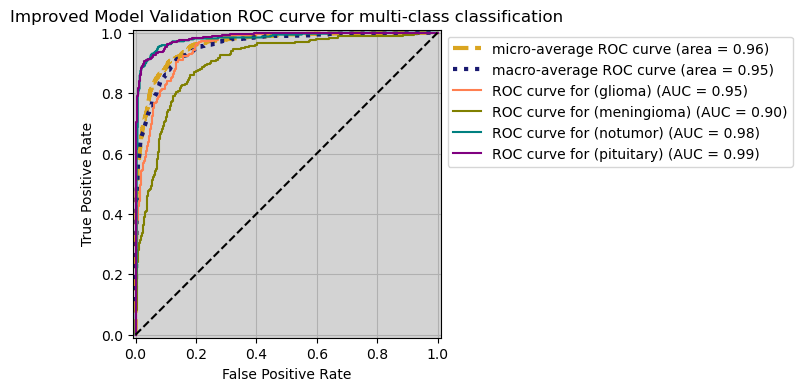

<Figure size 640x480 with 0 Axes>

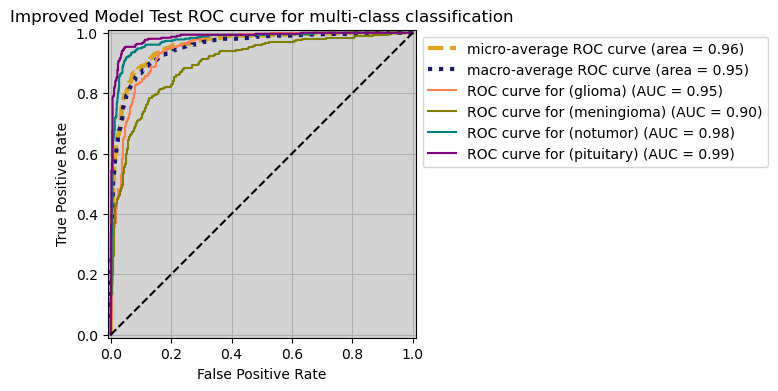

<Figure size 640x480 with 0 Axes>

In [19]:
# OPTIMIZED MODEL EVALUATION 

# Evaluation metrics
print(calculate_performance_measures(model, X_train, y_train, threshold=0.5))
print(calculate_performance_measures(model, X_val, y_val, threshold=0.5))
print(calculate_performance_measures(model, X_test, y_test, threshold=0.5))

# Show loss/accuracy plot
plot_loss_accuracy(model_history, "Improved Model")

# Predictions for entire validation dataset
y_pred_val_probs = model.predict(X_val)  # Predict for validation data samples
y_pred_val = np.argmax(y_pred_val_probs, axis=1)  # Get the predicted class index
y_true_val = np.argmax(y_val, axis=1)  # Get true class indices from one-hot encoded labels
    
# Predictions for entire test data set
y_pred_test_probs = model.predict(X_test)  # Predict for validation data samples
y_pred_test = np.argmax(y_pred_test_probs, axis=1)  # Get the predicted class index
y_true_test = np.argmax(y_test, axis=1)  # Get true class indices from one-hot encoded labels

# Show confusion matrices
confu_matrix(train_data, y_pred_val, y_true_val, "Improved Model", "Validation")
confu_matrix(train_data, y_pred_test, y_true_test, "Improved Model", "Test")

# Show ROC curves
calculate_roc(y_pred_val_probs, y_true_val, "Improved Model", "Validation")
calculate_roc(y_pred_test_probs, y_true_test, "Improved Model", "Test")



--------------------------------------------------------------------
[0.9415627051871307, 0.9460174262375068, 0.9415627051871307, 0.9417266815440305]

--------------------------------------------------------------------
[0.6657917760279966, 0.6649285871328204, 0.6657917760279966, 0.6595770808462118]

--------------------------------------------------------------------
[0.6727688787185355, 0.6711238686678141, 0.6727688787185355, 0.666808121784713]


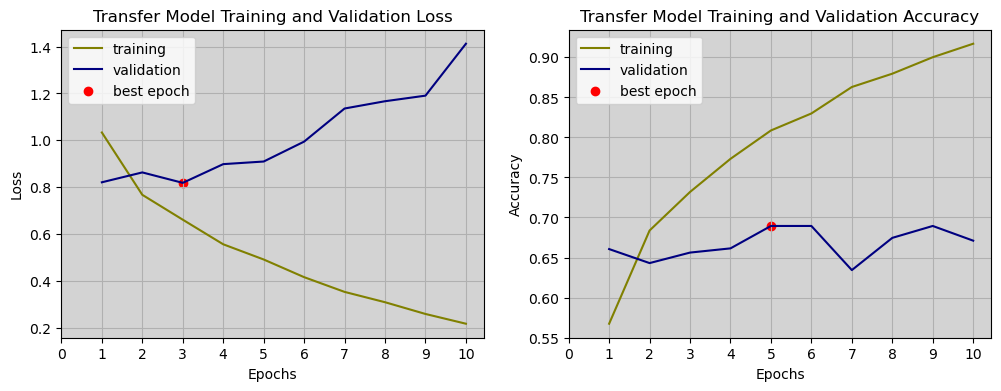

41/41 [==============================] - 61s 1s/step
[[158  47  31  22]
 [ 81 105  37  30]
 [ 12  10 272  24]
 [ 36  22  24 232]]
test_accuracy: 0.671


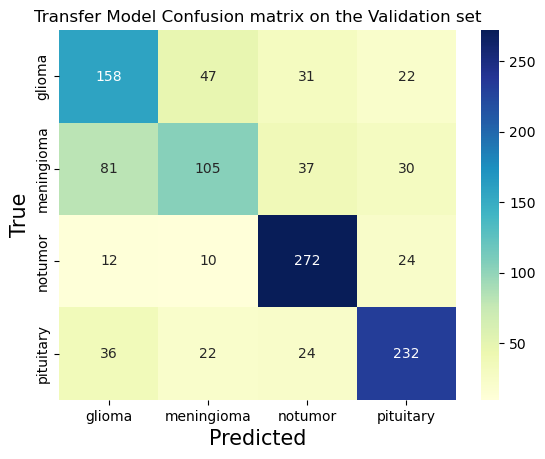

[[181  46  40  33]
 [ 53 147  71  35]
 [ 20  14 354  17]
 [ 55  26  18 201]]
test_accuracy: 0.674


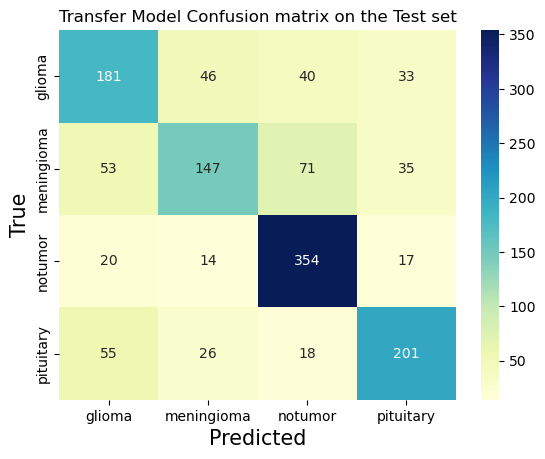

<Figure size 640x480 with 0 Axes>

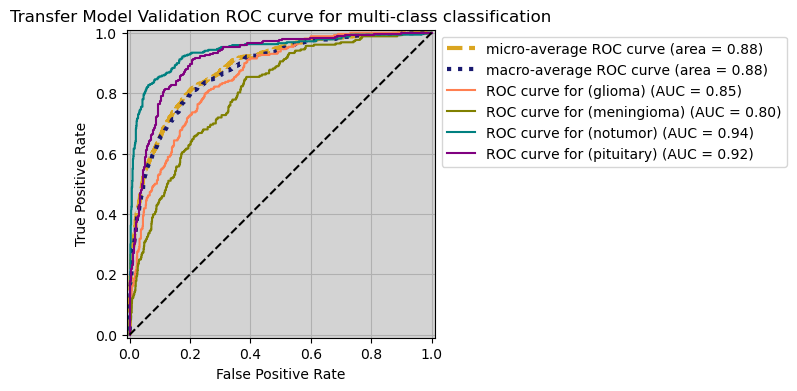

<Figure size 640x480 with 0 Axes>

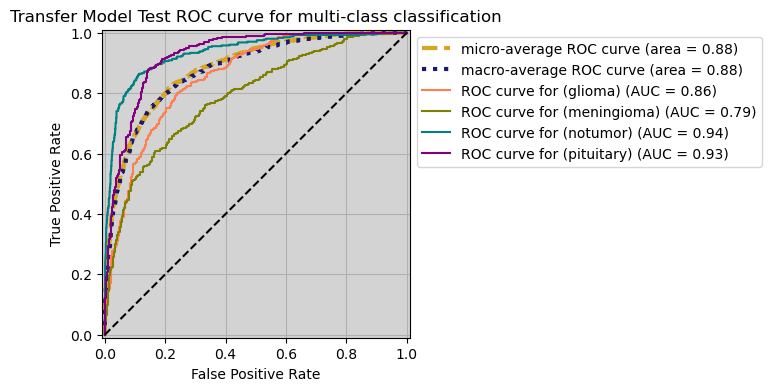

<Figure size 640x480 with 0 Axes>

In [21]:
# TRANSFER MODEL EVALUATION 

# Evaluation metrics
print(calculate_performance_measures(transfer_model, X_train, y_train, threshold=0.5))
print(calculate_performance_measures(transfer_model, X_val, y_val, threshold=0.5))
print(calculate_performance_measures(transfer_model, X_test, y_test, threshold=0.5))

# Show loss/accuracy plot
plot_loss_accuracy(transfer_history, "Transfer Model")

# Predictions for entire validation dataset
y_pred_val_probs = transfer_model.predict(X_val)  # Predict for validation data samples
y_pred_val = np.argmax(y_pred_val_probs, axis=1)  # Get the predicted class index
y_true_val = np.argmax(y_val, axis=1)  # Get true class indices from one-hot encoded labels
    
# Predictions for entire test data set
y_pred_test_probs = transfer_model.predict(X_test)  # Predict for validation data samples
y_pred_test = np.argmax(y_pred_test_probs, axis=1)  # Get the predicted class index
y_true_test = np.argmax(y_test, axis=1)  # Get true class indices from one-hot encoded labels

# Show confusion matrices
confu_matrix(train_data, y_pred_val, y_true_val, "Transfer Model", "Validation")
confu_matrix(train_data, y_pred_test, y_true_test, "Transfer Model", "Test")

# Show ROC curves
calculate_roc(y_pred_val_probs, y_true_val, "Transfer Model", "Validation")
calculate_roc(y_pred_test_probs, y_true_test, "Transfer Model", "Test")
